<title>Coastline image classification using ML Toolbox and Transfer Learning</title>
<h1>Coastline image classification using ML Toolbox and Transfer Learning</h1>

We have a bunch of aerial images of coastlines that were photographed from drones. They were then tagged into several categories based on their potential for flooding. We'd like to be able to train a machine learning model to identify the appropriate category that new drone images of a shoreline are depicting.
<p>
This dataset is courtesy of Texas A&M University (See https://storage.googleapis.com/tamucc_coastline/GooglePermissionForImages_20170119.pdf for details).
<p>
<h2> Dataset organization </h2>
<p>
Organize the dataset into two parts:
<ol>
<li> Upload the images to Google Cloud Storage.
<li> Create a BigQuery table that has two columns:  image_url and label.  The image_url is the GCS location and the label is the true classification type.
</ol>

In [ ]:
%bash
pip install pip==9.0.3
bq mk demos
bq rm -f demos.coastline_images
bq load \
   --source_format=CSV --skip_leading_rows=1 \
   demos.coastline_images \
   gs://tamucc_coastline/labeled_images.csv \
   image_url:string,short_label:string,label:string

This is what the labeled dataset looks like (To train on a different set of images, start with a BigQuery table that has these two columns).

In [5]:
import google.datalab.bigquery as bq

sql = "SELECT image_url, label FROM demos.coastline_images"
df = bq.Query(sql).execute().result().to_dataframe()
print 'Have a total of {} labeled images'.format(len(df))
df.head()

Have a total of 10533 labeled images


,image_url,label
0,gs://tamucc_coastline/esi_images/IMG_2417_SecD...,Sheltered tidal flats
1,gs://tamucc_coastline/esi_images/IMG_0919_SecB...,Sheltered tidal flats
2,gs://tamucc_coastline/esi_images/IMG_1835_SecD...,Sheltered tidal flats
3,gs://tamucc_coastline/esi_images/IMG_2547_SecA...,Sheltered tidal flats
4,gs://tamucc_coastline/esi_images/IMG_6530_SecF...,Sheltered tidal flats


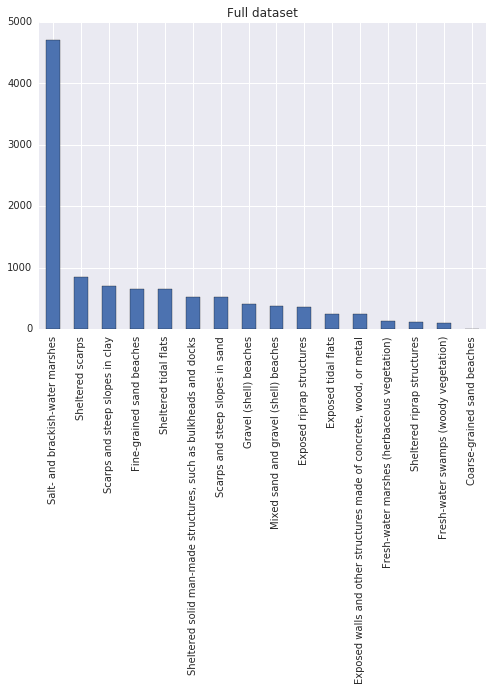

In [21]:
import matplotlib.pyplot as plt
import google.datalab.bigquery as bq
df = bq.Query("SELECT image_url, label FROM demos.coastline_images").execute().result().to_dataframe()
df['label'].value_counts().plot(kind='bar', title='Full dataset');

<h2> Create a smaller subset </h2>
<p>
Normally, of course, you would train on all your data. However, for learning purposes, we don't want you to wait hours at each stage. Therefore, let's intentionally use only a small subset of the entire dataset. When adapting this sample to work on your own data, skip over this section or comment out the subsample clause.

In [ ]:
%bash
QUERY='SELECT image_url, label FROM '
TABLE="${PROJECT_ID}.demos.coastline_images"
SUBSAMPLE='WHERE (short_label = "2A" OR short_label = "3A" OR short_label = "9") AND MOD(ABS(FARM_FINGERPRINT(image_url)), 10) = 0'
bq rm -f demos.coastline_train
bq query --use_legacy_sql=false  --destination_table=demos.coastline_train "$QUERY \`$TABLE\` $SUBSAMPLE"

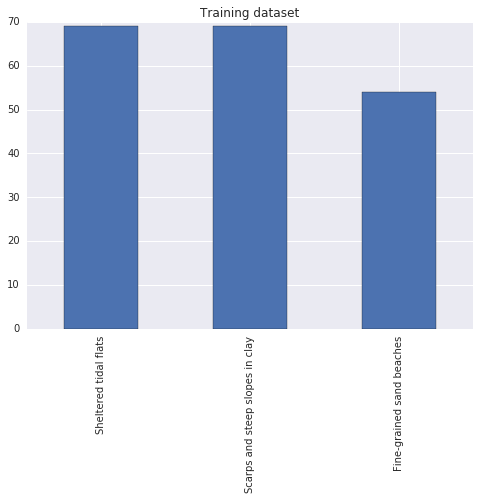

In [1]:
import matplotlib.pyplot as plt
import google.datalab.bigquery as bq
train_df = bq.Query("SELECT image_url, label FROM demos.coastline_train").execute().result().to_dataframe()
train_df['label'].value_counts().plot(kind='bar', title='Training dataset');

In [2]:
len(train_df)

192

<h2>Create bucket</h2>
<p>
Create a new bucket to hold your model etc. At the end of this lab, you can delete that bucket.

In [1]:
bucket = 'gs://' + datalab_project_id() + '-txf'
preprocessed_dir = bucket + '/preprocessed'
model_dir = bucket + '/model'

In [6]:
import subprocess
print 'Creating bucket named {}'.format(bucket)
subprocess.check_call('gsutil mb {}'.format(bucket).split());

Creating bucket named gs://cloud-training-demos-txf


<h2> Preprocessing </h2>
<p>
Now that we have the images in Cloud Storage and the labels in BigQuery, we can use Datalab's ML Toolbox to do transfer learning. This consists of three steps: (1) Preprocessing (2) Training, and (3) Deploying.

Preprocessing the images will resize the images, and do some image augmentation.  This would take about 3 hours for the 8000 coastline images. Even on 200 images, this will take about 30 minutes

In [7]:
import mltoolbox.image.classification as model
from google.datalab.ml import *
import os

train_set = BigQueryDataSet("SELECT image_url, label FROM demos.coastline_train")
job = model.preprocess_async(train_set, preprocessed_dir, cloud={'max_num_workers': 4})

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:132: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


Job "preprocess-image-classification-170624-200206" submitted. Click here to track preprocessing job.

<b> Wait! </b>
You have two options to proceed:
<ol>
<li> Monitor the above preprocessing job, and proceed with this notebook only after prepocessing is complete. The preprocessing job took about 30 minutes for me. You can explicitly wait for the job completion by running the Option 1 cell. Make sure to uncomment the last line in the cell.
<li> Stop the job from the Dataflow console and then copy the results of my run into your GCS bucket by running the Option 2 cell. Make sure to uncomment the last 2 lines in the cell.
</ol>

In [ ]:
# option 1 above. Wait for your preprocessing job to complete.
# If you choose this option, uncomment the next line and run this cell.
# job.wait()

In [ ]:
%bash
# option 2 above. Copy my preprocessing results and move on.
# If you choose this option, uncomment the last two lines and run this cell.
FROM=gs://cloud-training-demos/coastline/preprocessed
TO="gs://${PROJECT_ID}-txf"
#echo "Copying already preprocessed files from $FROM to $TO"
#gsutil -m cp -r $FROM $TO

<h2> Training </h2>
<p>
Train the last few layers of the inception model based on our images.

In [6]:
import mltoolbox.image.classification as model
from google.datalab.ml import *
job = model.train_async(preprocessed_dir, 32, 5000, model_dir,  # batchsize, numsteps
                  cloud=CloudTrainingConfig('us-central1', 'BASIC'))

Job "image_classification_train_170625_055535" submitted. Click here to view cloud log.

Wait for the above job to complete before proceeding to next step (monitor job progress on the GCP console under ML Engine | Jobs).  It should take about 15 minutes to complete.
The training log may contain harmless warnings and errors. Please check the message `Task completed successfully` at the end of the log to confirm the successful completion.
<p>
<h2> Evaluation </h2>

In [9]:
from google.datalab.ml import *
print model_dir
tb_id = TensorBoard.start(model_dir)

gs://cloud-training-demos-txf/model


TensorBoard was started successfully with pid 31309. Click here to access it.

In [11]:
TensorBoard.stop(tb_id)

When I did it, I got 85% accuracy on the held-out (evaluation dataset). This is not bad considering that we started with just about 200 images!
<p>
<h2> Deploy and predict model </h2>
<p>
Deploy the trained model as a web service. This simply a short cut to the underlying gcloud commands.

In [10]:
Models().create('coastline')
ModelVersions('coastline').deploy('v1', model_dir)

Waiting for operation "projects/cloud-training-demos/operations/create_coastline_v1-1498444496288"
Done.


Once the model is deployed, we can send along an image and we will get back the classification probabilities. (these images are not among the 200 or so images used in training or in evaluation)

Predicting...


Sheltered tidal flats(0.71116)

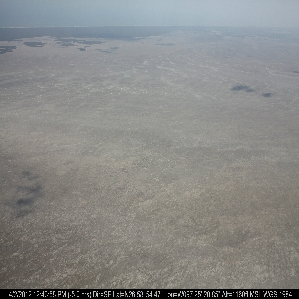

Scarps and steep slopes in clay(0.99917)

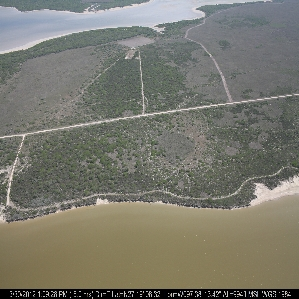

Fine-grained sand beaches(0.99751)

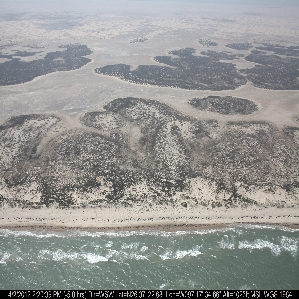

,image_url,label,score
0,gs://tamucc_coastline/esi_images/IMG_2007_SecD...,Sheltered tidal flats,0.711160
1,gs://tamucc_coastline/esi_images/IMG_0297_SecB...,Scarps and steep slopes in clay,0.999175
2,gs://tamucc_coastline/esi_images/IMG_3264_SecD...,Fine-grained sand beaches,0.997513


In [22]:
images = [
  'gs://tamucc_coastline/esi_images/IMG_2007_SecDE_Spr12.jpg', # sheltered tidal flats
  'gs://tamucc_coastline/esi_images/IMG_0297_SecBC_Spr12.jpg', # scarps and steep slopes in clay
  'gs://tamucc_coastline/esi_images/IMG_3264_SecDE_Spr12.jpg', # sand-grained beaches
]
# resize=True because otherwise the images are too large to send for online prediction.
model.predict('coastline.v1', images, resize=True, cloud=True)